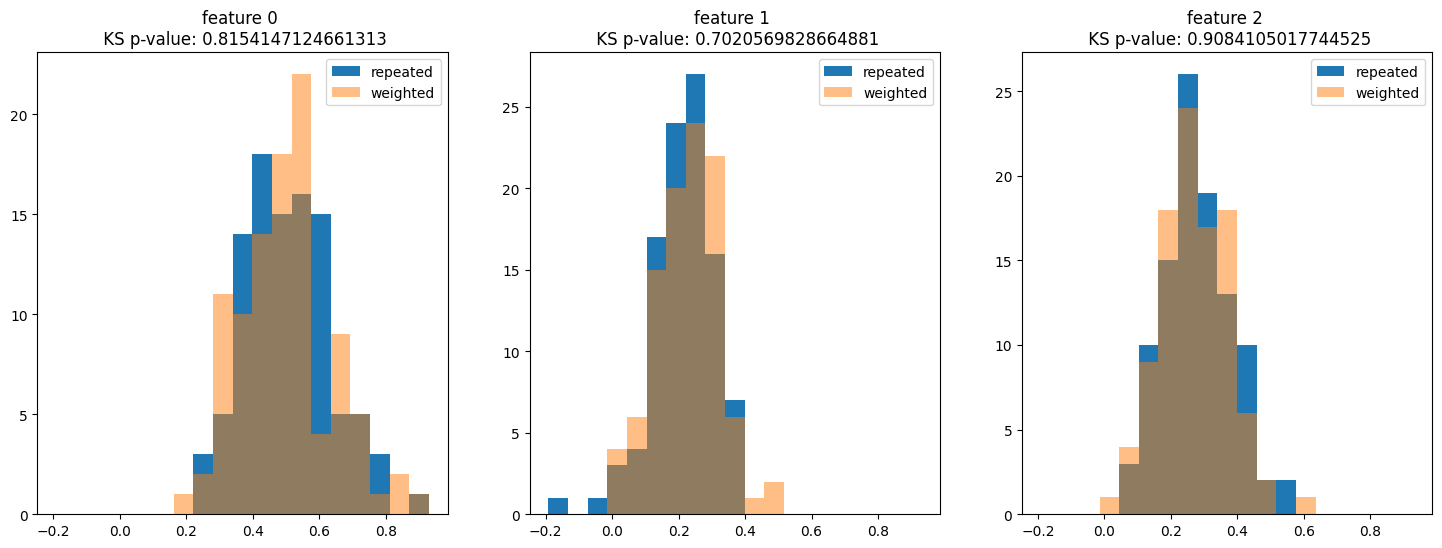

In [26]:
import numpy as np
from scipy.stats import kstest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.utils.validation import check_random_state
from sklearn.utils import shuffle



def test_feature_importance_sample_weight_equals_repeated(est_name, global_random_seed):
    # check that setting sample_weight to zero / integer is equivalent
    # to removing / repeating corresponding samples.
    n_rep = 100
    res_repeated = []
    res_weighted = []
    rng = check_random_state(global_random_seed)

    n_samples = 100
    n_features = 3
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_features,
        n_redundant=0,
    )
    for rep in range(n_rep):
        params = dict(
            n_estimators=20,
            bootstrap=True,
            oob_score=True,
            max_features=1.0,
            random_state=rng,
        )

        est_weighted = est_name(**params)
        est_repeated = est_name(**params)

        # Use random integers (including zero) as weights.
        sw = rng.randint(0, 2, size=n_samples)

        X_weighted = X
        y_weighted = y
        # repeat samples according to weights
        X_repeated = X_weighted.repeat(repeats=sw, axis=0)
        y_repeated = y_weighted.repeat(repeats=sw)

        X_weighted, y_weighted, sw = shuffle(X_weighted, y_weighted, sw, random_state=rng)

        est_repeated.fit(X_repeated, y=y_repeated, sample_weight=None)
        est_weighted.fit(X_weighted, y=y_weighted, sample_weight=sw)
        res_repeated.append(est_repeated.ufi_feature_importances_)
        res_weighted.append(est_weighted.ufi_feature_importances_)
    
    res_repeated = np.array(res_repeated)
    res_weighted = np.array(res_weighted)
    
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots(1,n_features,figsize=(n_features*6,6))
    min_of_min = min(res_repeated.min(), res_weighted.min())
    max_of_max = max(res_repeated.max(), res_weighted.max())

    bins = np.linspace(min_of_min, max_of_max, 20)
    for i in range(n_features):
        pval = kstest(res_repeated[:, i], res_weighted[:, i]).pvalue
        assert pval > 0.05
        ax[i].hist(res_repeated[:,i],label='repeated', bins=bins)
        ax[i].hist(res_weighted[:,i],alpha=0.5,label='weighted', bins=bins)
        ax[i].legend()
        ax[i].set_title(f'feature {i} \n KS p-value: {pval}')
    plt.show()

test_feature_importance_sample_weight_equals_repeated(RandomForestClassifier, 1)

/home/gaeta/dev/scikit-learn/sklearn/ensemble/_forest.py:755: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/gaeta/dev/scikit-learn/sklearn/ensemble/_forest.py:755: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/gaeta/dev/scikit-learn/sklearn/ensemble/_forest.py:755: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/gaeta/dev/scikit-learn/sklearn/ensemble/_forest.py:755: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/gaeta/dev/scikit-learn/sklearn/ensemble/_forest.py:755: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates

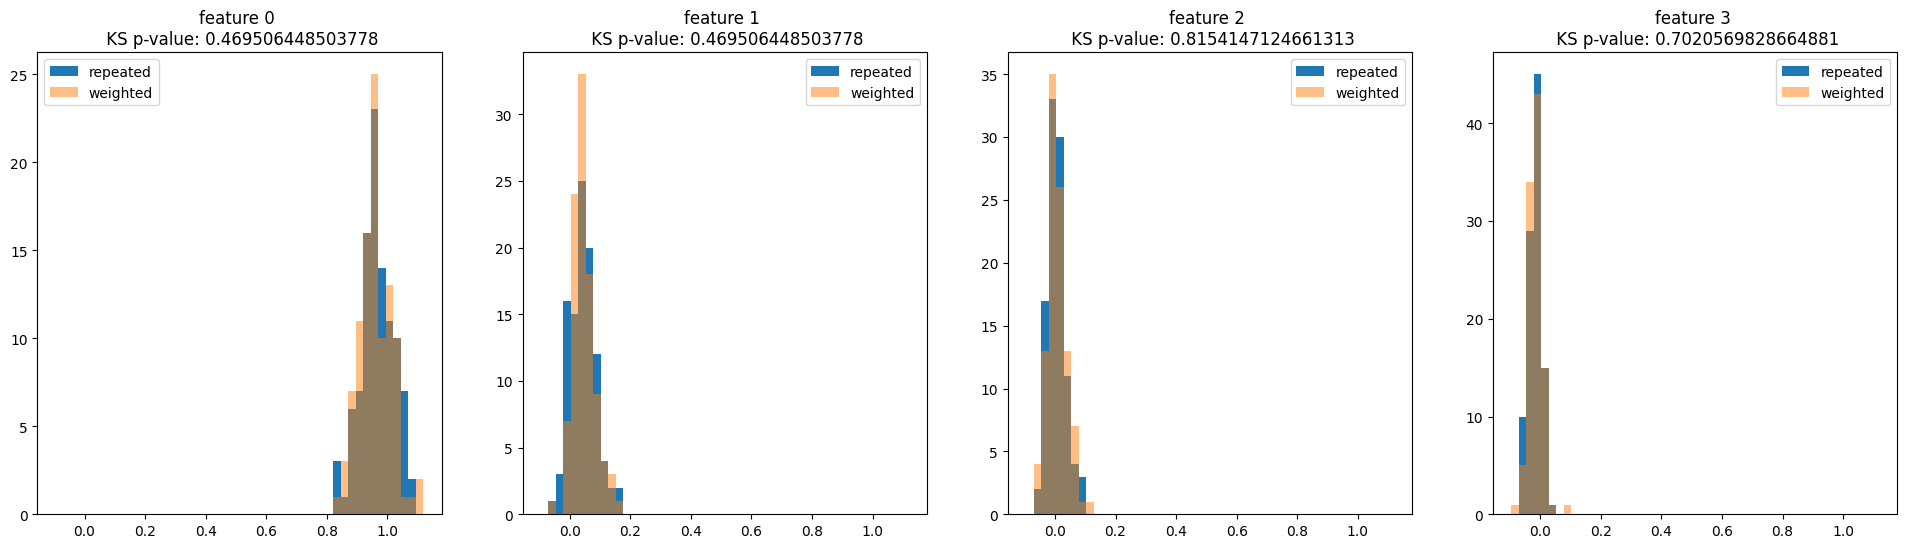

In [1]:
import numpy as np
from scipy.stats import kstest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.utils.validation import check_random_state
from sklearn.utils import shuffle

from sklearn.base import is_classifier
from sklearn.datasets import make_regression
def test_feature_importance_with_sample_weights(est_name, global_random_seed):
    n_samples = 250
    n_features = 4
    n_classes = 2
    max_sample_weight = 5

    rng = check_random_state(global_random_seed)
    n_samples_sw = int(0.8 * n_samples)  # small weights
    n_samples_lw = n_samples - n_samples_sw  # large weights
    n_features_sw = n_features // 2
    n_features_lw = n_features - n_features_sw

    # Construct the sample weights: mostly zeros and some ones for the first
    # dataset, and some random integers larger than one for the second dataset.
    sample_weight_sw = np.where(rng.random(n_samples_sw) < 0.2, 1, 0)
    sample_weight_lw = rng.randint(2, max_sample_weight, size=n_samples_lw)
    total_weight_sum = np.sum(sample_weight_sw) + np.sum(sample_weight_lw)
    assert np.sum(sample_weight_sw) < 0.3 * total_weight_sum

    est = est_name()
    if not is_classifier(est):
        X_sw, y_sw = make_regression(
            n_samples=n_samples_sw,
            n_features=n_features_sw,
            random_state=rng,
        )
        X_lw, y_lw = make_regression(
            n_samples=n_samples_lw,
            n_features=n_features_lw,
            random_state=rng,  # rng is different because mutated
        )
    else:
        X_sw, y_sw = make_classification(
            n_samples=n_samples_sw,
            n_features=n_features_sw,
            n_informative=n_features_sw,
            n_redundant=0,
            n_repeated=0,
            n_classes=n_classes,
            random_state=rng,
        )
        X_lw, y_lw = make_classification(
            n_samples=n_samples_lw,
            n_features=n_features_lw,
            n_informative=n_features_lw,
            n_redundant=0,
            n_repeated=0,
            n_classes=n_classes,
            random_state=rng,  # rng is different because mutated
        )

    # Horizontally pad the features with features values marginally sampled
    # from the other dataset.
    pad_sw_idx = rng.choice(n_samples_lw, size=n_samples_sw, replace=True)
    X_sw_padded = np.hstack([X_sw, np.take(X_lw, pad_sw_idx, axis=0)])

    pad_lw_idx = rng.choice(n_samples_sw, size=n_samples_lw, replace=True)
    X_lw_padded = np.hstack([np.take(X_sw, pad_lw_idx, axis=0), X_lw])

    # Vertically stack the two datasets and shuffle them.
    X = np.concatenate([X_sw_padded, X_lw_padded], axis=0)
    y = np.concatenate([y_sw, y_lw])

    sample_weight = np.concatenate([sample_weight_sw, sample_weight_lw])
    X, y, sample_weight = shuffle(X, y, sample_weight, random_state=rng)

    X_weighted, y_weighted = X, y
    X_repeated = X.repeat(repeats=sample_weight, axis=0)
    y_repeated = y.repeat(repeats=sample_weight)

    n_rep = 100
    res_repeated = []
    res_weighted = []
    for rep in range(n_rep):
        params = dict(
            n_estimators=20,
            bootstrap=True,
            oob_score=True,
            max_features=1.0,
            random_state=rng,
        )

        est_weighted = est_name(**params)
        est_repeated = est_name(**params)

        # Use random integers (including zero) as weights.
        sw = rng.randint(0, 2, size=n_samples)

        X_weighted = X
        y_weighted = y
        # repeat samples according to weights
        X_repeated = X_weighted.repeat(repeats=sw, axis=0)
        y_repeated = y_weighted.repeat(repeats=sw)

        X_weighted, y_weighted, sw = shuffle(X_weighted, y_weighted, sw, random_state=rng)

        est_repeated.fit(X_repeated, y=y_repeated, sample_weight=None)
        est_weighted.fit(X_weighted, y=y_weighted, sample_weight=sw)
        res_repeated.append(est_repeated.ufi_feature_importances_)
        res_weighted.append(est_weighted.ufi_feature_importances_)
    
    res_repeated = np.array(res_repeated)
    res_weighted = np.array(res_weighted)
    
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots(1,n_features,figsize=(n_features*6,6))
    min_of_min = min(res_repeated.min(), res_weighted.min())
    max_of_max = max(res_repeated.max(), res_weighted.max())
    bins = np.linspace(min_of_min, max_of_max, 50)

    for i in range(n_features):
        pval = kstest(res_repeated[:, i], res_weighted[:, i]).pvalue
        assert pval > 0.05
        ax[i].hist(res_repeated[:,i],label='repeated', bins=bins)
        ax[i].hist(res_weighted[:,i],alpha=0.5,label='weighted', bins=bins)
        ax[i].legend()
        ax[i].set_title(f'feature {i} \n KS p-value: {pval}')
    plt.show()

test_feature_importance_with_sample_weights(RandomForestClassifier, 2)

    
    
